In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

In [2]:
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

In [3]:
def plot_image(image):
    nr, nc = image.shape
    extent = [-0.5, nc - 0.5, nr - 0.5, -0.5]
    plt.imshow(image, extent=extent, origin='upper', interpolation='nearest')

def visualize(t, loss, errcl, x5, x4, x3, x0, w1):

    loss_avg = np.divide(
        np.cumsum(loss[: t + 1]),
        range(1, t + 2)
    )

    errcl_avg = np.divide(
        np.cumsum(errcl[: t + 1]),
        range(1, t + 2)
    )

    n_last_batches = np.min([20, t])
    k = np.ones(n_last_batches * 2 + 1) / (n_last_batches + 1)
    k[:n_last_batches] = 0
    
    errcl_sm = np.convolve(np.pad(errcl, mode="edge", pad_width=n_last_batches), k, mode="valid")
    errcl_sm = errcl_sm[: len(errcl_avg)]

    loss_sm = np.convolve(np.pad(loss, mode="edge", pad_width=n_last_batches), k, mode="valid")
    loss_sm = loss_sm[: len(loss)]

    display.clear_output(wait=True)

    plt.subplot(4, 3, 1)
    plt.plot(loss, label="loss")
    plt.plot(loss_sm, label="smothed loss")
    plt.plot(loss_avg, label="avg loss")
    plt.legend()
    plt.ylim(0, np.max(loss)*1.05)
    plt.title("loss: avg - %.4f, smoothed - %.4f, current - %.4f"  % (loss_avg[t], loss_sm[t], loss[t]))

    plt.subplot(4, 3, 2)
    plt.plot(errcl, label="cl err")
    plt.plot(errcl_sm, label="smothed cl err")
    plt.plot(errcl_avg, label="avg cl err")
    plt.legend()
    plt.ylim(0, np.max(errcl)*1.05)
    plt.title("cl error: avg - %.4f, smoothed - %.4f, current - %.4f"  % (errcl_avg[t], errcl_sm[t], errcl[t]))
    
    plt.subplot(4, 3, 3)
    plt.bar(range(len(x5)), x5)
    plt.title("class confidences")

    plt.subplot(4,3,4)
    plt.hist(x4)
    plt.title("F6 activations")

    plt.subplot(4,3,5)
    plt.hist(x3)
    plt.title("C5 activations")

    plt.subplot(4,3,6)
    plot_image(x0)
    plt.title("input image")

    for i in range(w1.shape[0]):
        plt.subplot(4,3,7+i)
        plot_image(w1[i])
        plt.title("C1 kernel channel " + str(i))

    plt.subplots_adjust(wspace=0.5)
    plt.subplots_adjust(hspace=0.5)
    plt.gcf().set_size_inches(18.5, 10.5)
    display.display(plt.gcf())

In [8]:
import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

mnist = torchvision.datasets.MNIST(root='data', train=True, download=True) # train data only
trainimages = mnist.data
trainlabels = mnist.targets


print("Training Data shape is: ", list(trainimages.size()))
print("Training Target shape is: ", list(trainlabels.size()))

Training Data shape is:  [60000, 28, 28]
Training Target shape is:  [60000]


In [11]:
class LeNet5(nn.Module):

    # definition of each neural network layer
    def __init__(self):
        super(LeNet5, self).__init__()
        self.C1 = nn.Conv2d(1, 6, kernel_size=(5, 5))
        self.S2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C3 = nn.Conv2d(6, 16, kernel_size=(5, 5))
        self.S4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C5 = nn.Conv2d(16, 120, kernel_size=(5, 5))
        self.F6 = nn.Linear(120, 84)

        self.OL = nn.Linear(84, 10)
        
        self.record = {"C5":None, "F6":None}

    def forward(self, x):
        
        x = torch.tanh(self.C1(x))
        x = self.S2(x)
        x = torch.tanh(self.C3(x))
        x = self.S4(x)
        x = torch.tanh(self.C5(x))
        x = x.view(x.size(0), -1) 
        
        self.record["C5"] = x.clone().detach().numpy()

        x = torch.tanh(self.F6(x))

        self.record["F6"] = x.clone().detach().numpy()

        x = torch.tanh(self.OL(x))
        
        return x

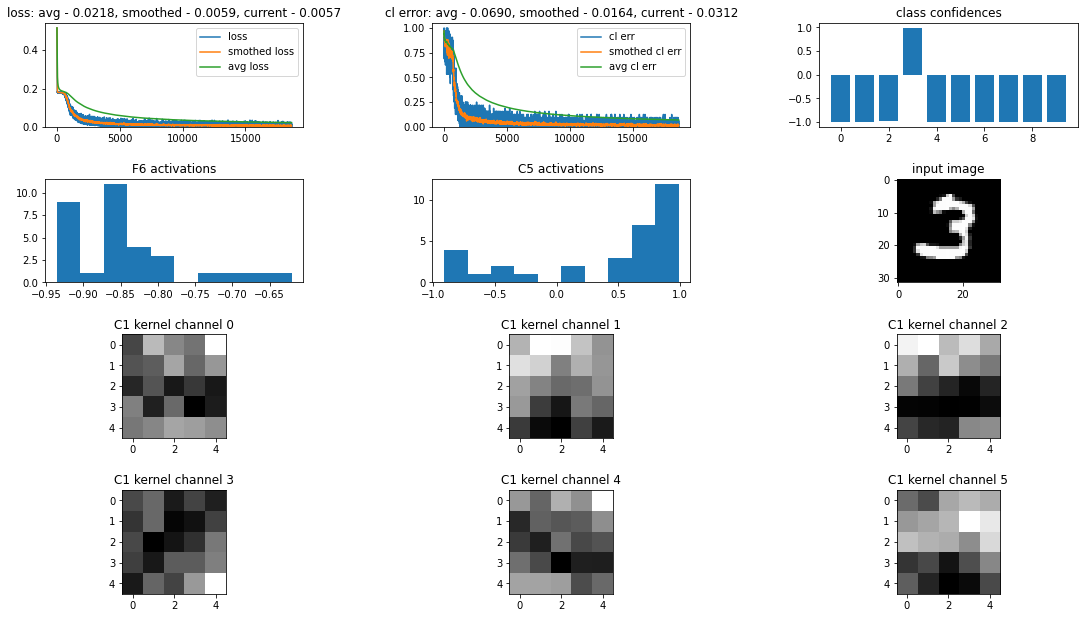

6.437827110290527 seconds per 100 iterations


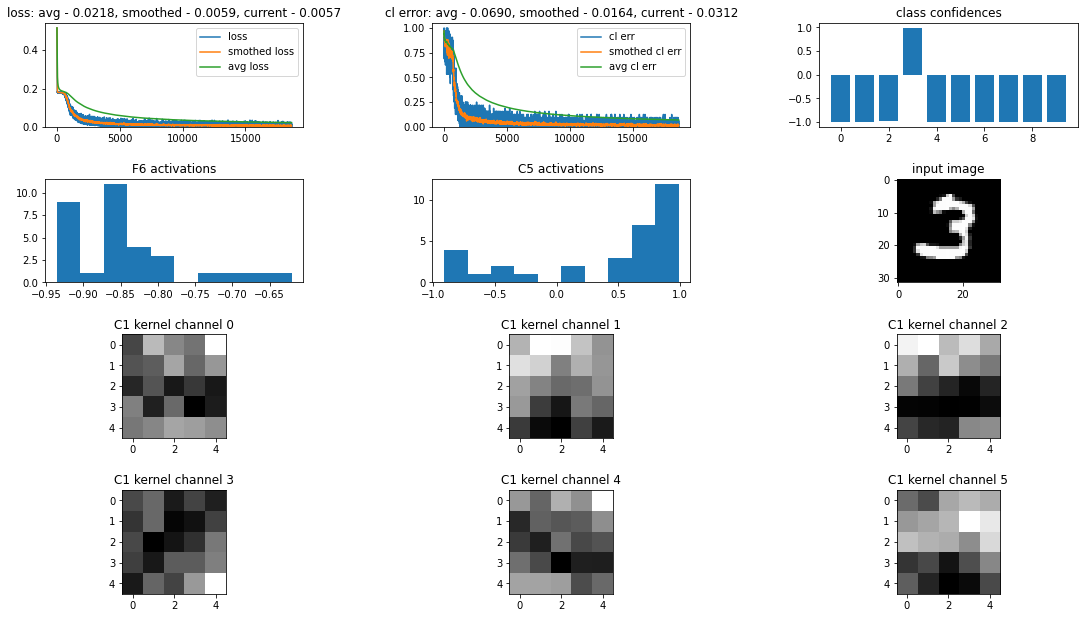

In [12]:
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10;                    # number of epochs through training set
disp_freq = 100                 # display frequency
batchsize = 32                  # minibatch size

errs = []
losses = []

lenet5 = LeNet5()


optimizer = optim.SGD(lenet5.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        
        y = torch.ones(10, batchsize) * (-1)
        y[trainlabels_iter, torch.arange(batchsize, dtype=torch.int64)] = 1
        imgs = torch.zeros([batchsize, 1, 32, 32])
        imgs[:, 0, 2: -2, 2: -2] = trainimages[batchindices].float() / 255.
        optimizer.zero_grad()
        out = lenet5(imgs)
        loss = torch.mean(0.5*(y - out.t())**2)
        loss.backward()
        optimizer.step()
        
        pred = torch.argmax(out, dim=1)
        err = torch.mean((pred != trainlabels_iter).float())
        errs.append(err.detach().numpy())
        losses.append(loss.detach().numpy())

        
        if (t + 1) % disp_freq == 0:
            plt.gcf().clear()
            visualize(len(errs) - 1, losses, errs, out[0,:].detach(), lenet5.record["F6"][:, 0], 
                      lenet5.record["C5"][:, 0], imgs[0, 0].detach(), lenet5.C1.weight.detach().squeeze())
            print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
            t_start = time.time()
            time.sleep(0.01)

In [13]:
class LeNet5_Relu(nn.Module):

    # definition of each neural network layer
    def __init__(self):
        super(LeNet5_Relu, self).__init__()
        self.C1 = nn.Conv2d(1, 6, kernel_size=(5, 5))
        self.S2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C3 = nn.Conv2d(6, 16, kernel_size=(5, 5))
        self.S4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        
        ####### Complete the defition of F5 #################
        
        self.F5 = nn.Linear(16,120)

        #####################################################

        self.F6 = nn.Linear(120, 84)

        # output layer
        self.OL = nn.Linear(84, 10)
        
        # record C5 & C6 activation for visualization
        self.record = {"F5":None, "F6":None}

    # definition of the forward pass
    def forward(self, x):
        
        ####### Complete the foward pass C1 >> F5 ##########
        
        x = torch.relu(self.C1(x))
        x = self.S2(x)
        x = torch.relu(self.C3(x))
        x = self.S4(x)
    

        #####################################################

        self.record["F5"] = x.clone().detach().numpy()
        x = torch.relu(self.F6(x))
        self.record["F6"] = x.clone().detach().numpy()
        x = functional.softmax(self.OL(x), dim=1)
        
        return x

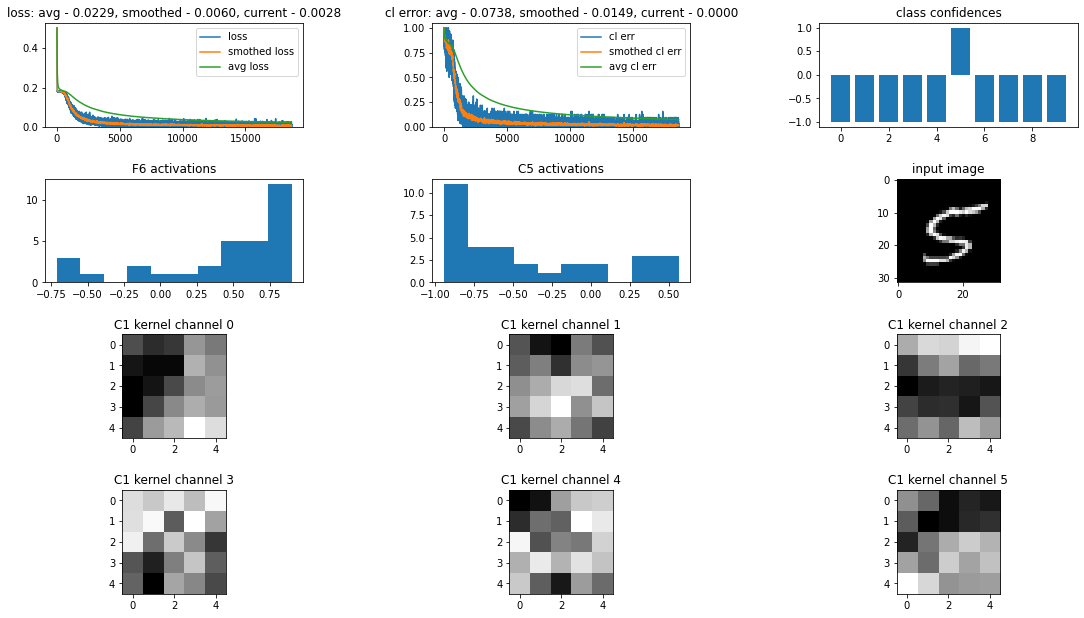

5.114994764328003 seconds per 100 iterations


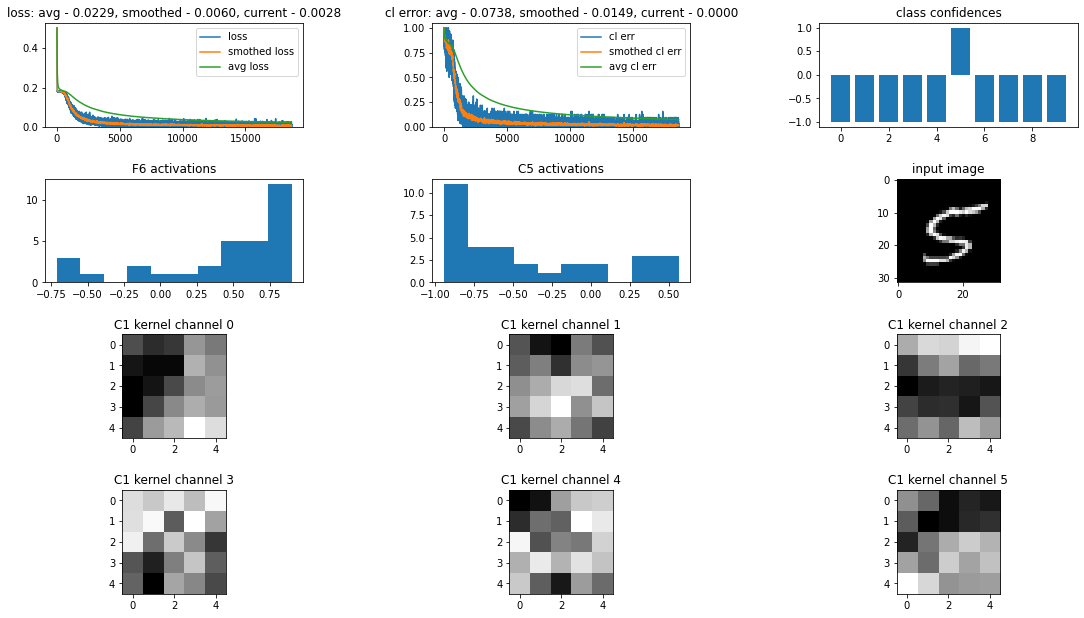

In [14]:
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10;                    # number of epochs through training set
disp_freq = 100                 # display frequency
batchsize = 32                  # minibatch size

errs = []
losses = []

lenet5 = LeNet5()


optimizer = optim.SGD(lenet5.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        
        y = torch.ones(10, batchsize) * (-1)
        y[trainlabels_iter, torch.arange(batchsize, dtype=torch.int64)] = 1
        imgs = torch.zeros([batchsize, 1, 32, 32])
        imgs[:, 0, 2: -2, 2: -2] = trainimages[batchindices].float() / 255.
        optimizer.zero_grad()
        out = lenet5(imgs)
        loss = torch.mean(0.5*(y - out.t())**2)
        loss.backward()
        optimizer.step()
        
        pred = torch.argmax(out, dim=1)
        err = torch.mean((pred != trainlabels_iter).float())
        errs.append(err.detach().numpy())
        losses.append(loss.detach().numpy())

        
        if (t + 1) % disp_freq == 0:
            plt.gcf().clear()
            visualize(len(errs) - 1, losses, errs, out[0,:].detach(), lenet5.record["F6"][:, 0], 
                      lenet5.record["C5"][:, 0], imgs[0, 0].detach(), lenet5.C1.weight.detach().squeeze())
            print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
            t_start = time.time()
            time.sleep(0.01)